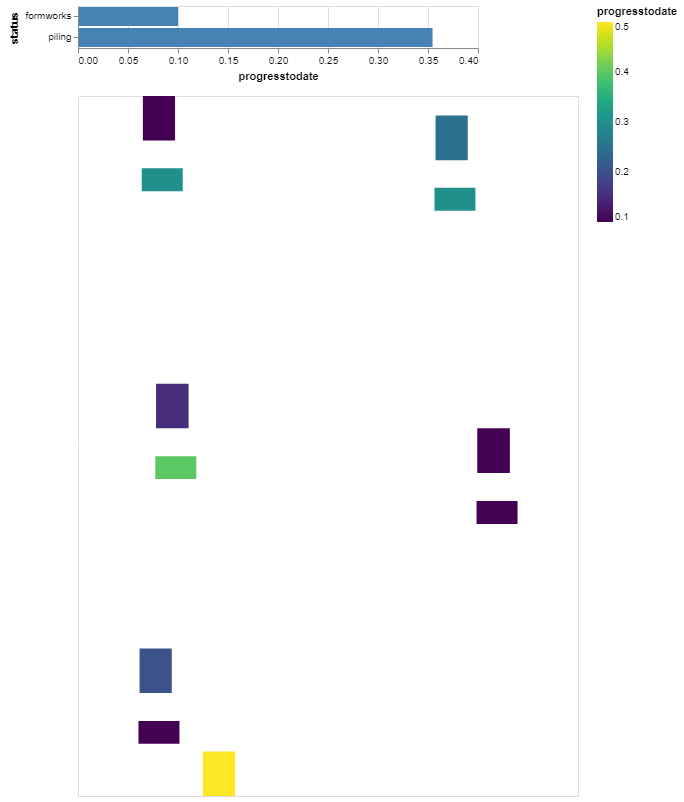

In [4]:
import pandas as pd
import altair as alt
import geopandas as gpd
import json

gdf = gpd.read_file("https://raw.githubusercontent.com/djouallah/R_leaflet_MAP/master/foundation_geo.json")

data=pd.read_csv("https://raw.githubusercontent.com/djouallah/R_leaflet_MAP/master/data/data1.csv")

# dump as json
json_gdf = gdf.to_json()
# load as a GeoJSON object.
json_features = json.loads(json_gdf)


# parse variable `features` from json_features to `alt.Data`
data_geo = alt.Data(values=json_features['features'])

# plot map, where variables ares nested within `properties`, 

pts = alt.selection(type='multi', fields=['status'])

bar = alt.Chart(data).transform_aggregate(
    max_budget='sum(budget)',
    sum_Installed_qty='sum(progress)',
    groupby=['status']
).transform_calculate(
    progresstodate='datum.sum_Installed_qty/ datum.max_budget'
).mark_bar().encode(
     x='progresstodate:Q',
    y='status:N',
    tooltip=[alt.Text('progresstodate:Q', format=',.2%')],
   
    color=alt.condition(pts, alt.ColorValue("steelblue"), alt.ColorValue("grey"))
   ).add_selection(
    pts
    )
map= alt.Chart(data).transform_filter(pts).transform_lookup(
    lookup='id',
    from_=alt.LookupData(data_geo, 'properties.id'),
    as_="geom"
).transform_aggregate(
    max_budget='sum(budget)',
    sum_Installed_qty='sum(progress)',
    groupby=['id','geom']
).transform_calculate(
    progresstodate='datum.sum_Installed_qty/ datum.max_budget',
    geometry ='datum.geom.geometry',
    type= 'datum.geom.type'
).mark_geoshape().properties(width=500,
    height=700
).encode(
     color='progresstodate:Q',
     tooltip=[alt.Text('progresstodate:Q', format=',.2%'),'id:N']
     
     )

chart = alt.vconcat(bar,map)
chart.save('docs/index.html')
chart